In [1]:
import json, os
import cv2
import torch
from aquabyte.data_access_utils import S3AccessUtils, RDSAccessUtils
from aquabyte.akpd import AKPD
from aquabyte.accuracy_metrics import AccuracyMetricsGenerator
from aquabyte.template_matching import find_matches_and_homography
from aquabyte.data_loader import KeypointsDataset, NormalizeCentered2D, ToTensor, BODY_PARTS
from aquabyte.optics import euclidean_distance, pixel2world, depth_from_disp, convert_to_world_point
import random

import torch
import pandas as pd

from torch import nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils

In [67]:
import matplotlib.pyplot as plt

In [82]:
from sqlalchemy import create_engine
from urllib.parse import urlparse


# sql_engine = create_engine(..)

db_connection = sql_engine.connect()

In [13]:
query = """
    select * from research.fish_metadata a left join keypoint_annotations b
    on a.left_url = b.left_image_url 
    where b.keypoints -> 'leftCrop' is not null
    and b.keypoints -> 'rightCrop' is not null
    and b.is_qa = false
    order by b.captured_at
"""
results = db_connection.execute(query)
df_gtsf = pd.DataFrame(results.fetchall())
df_gtsf.columns = results.keys()

In [14]:
df_gtsf.head(3)

,left_url,fish_id,weight,data,stereo_parameters_url,ts_created,ts_updated,data_collection_type_id,id,fish_detection_id,...,site_id,pen_id,left_image_url,right_image_url,left_crop_metadata,right_crop_metadata,camera_metadata,captured_at,is_obscured_floy_tag,is_floy_tag_not_present
0,https://s3-eu-west-1.amazonaws.com/aquabyte-cr...,190301010002,2427,"{'species': 'salmon', 'location': 'Generic', '...",https://aquabyte-stereo-parameters.s3-eu-west-...,2019-08-09 05:30:21.884070+00:00,2019-08-09 05:30:21.884070+00:00,None,509178,None,...,35,48,https://s3-eu-west-1.amazonaws.com/aquabyte-cr...,https://s3-eu-west-1.amazonaws.com/aquabyte-cr...,"{'width': 2339, 'height': 702, 'x_coord': 634,...","{'width': 2319, 'height': 709, 'x_coord': 172,...","{'baseline': 0.12693501988129197, 'focalLength...",2019-03-01 09:07:45.908000+00:00,None,None
1,https://s3-eu-west-1.amazonaws.com/aquabyte-cr...,190301010003,2300,"{'species': 'salmon', 'location': 'Generic', '...",https://aquabyte-stereo-parameters.s3-eu-west-...,2019-08-09 05:30:19.685998+00:00,2019-08-09 05:30:19.685998+00:00,None,509176,None,...,35,48,https://s3-eu-west-1.amazonaws.com/aquabyte-cr...,https://s3-eu-west-1.amazonaws.com/aquabyte-cr...,"{'width': 2340, 'height': 714, 'x_coord': 642,...","{'width': 2278, 'height': 684, 'x_coord': 213,...","{'baseline': 0.12693501988129197, 'focalLength...",2019-03-01 09:10:40.248000+00:00,None,None
2,https://s3-eu-west-1.amazonaws.com/aquabyte-cr...,190301010004,1903,"{'species': 'salmon', 'location': 'Generic', '...",https://aquabyte-stereo-parameters.s3-eu-west-...,2019-08-09 05:30:22.664575+00:00,2019-08-09 05:30:22.664575+00:00,None,509179,None,...,35,48,https://s3-eu-west-1.amazonaws.com/aquabyte-cr...,https://s3-eu-west-1.amazonaws.com/aquabyte-cr...,"{'width': 2216, 'height': 637, 'x_coord': 684,...","{'width': 2238, 'height': 654, 'x_coord': 205,...","{'baseline': 0.12693501988129197, 'focalLength...",2019-03-01 09:13:18.999000+00:00,None,None


# weight bucket breakdown 

In [17]:
df_gtsf["weight"].describe()

count    16085.000000
mean      5250.180665
std       1725.619255
min        169.000000
25%       4298.000000
50%       5234.000000
75%       6340.000000
max       9290.000000
Name: weight, dtype: float64

In [19]:
interval_range = pd.interval_range(start=0, freq=100, end=10000, closed='left')

In [30]:
weight_bin = pd.cut(df_gtsf["weight"], bins=interval_range)


In [31]:
weight_bin_count = weight_bin.value_counts().sort_index()

In [64]:
weight_bin_count.to_csv('output/weight_counts.csv', 
                        index=True, 
                        header = ['count'])

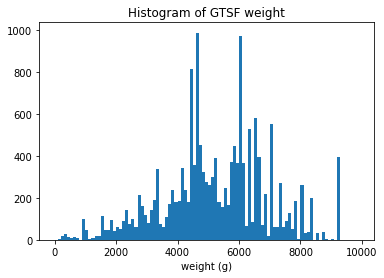

In [81]:
_ = plt.hist(df_gtsf['weight'], bins=[a for a in range(0, 10000, 100)])  # arguments are passed to np.histogram
#_ = plt.hist(orientation, bins=20)
plt.title("Histogram of GTSF weight")
plt.xlabel('weight (g)')
plt.show()

# K factor breakdown 
## KF = (10^5) * (weight_in_grams) / (length_in_mm)^3

In [50]:
def get_length(sf_data):
    try:
        return sf_data['lengthMms']
    except IndexError:
        return None
    

In [51]:
df_gtsf['k_factor'] = 10**5 * df_gtsf['weight'] / df_gtsf.data.apply(get_length) ** 3

In [56]:
df_gtsf['k_factor'].describe()

count    16085.000000
mean         1.234984
std          0.154954
min          0.003836
25%          1.128905
50%          1.229758
75%          1.353973
max          3.396764
Name: k_factor, dtype: float64

In [57]:
k_interval_range = pd.interval_range(start=0, freq=0.1, end=3.5, closed='left')
kf_bin = pd.cut(df_gtsf["k_factor"], bins=k_interval_range)
kf_bin_count = kf_bin.value_counts().sort_index()

In [65]:
kf_bin_count.to_csv('output/kf_counts.csv', 
                    index=True,
                    header = ['count'])

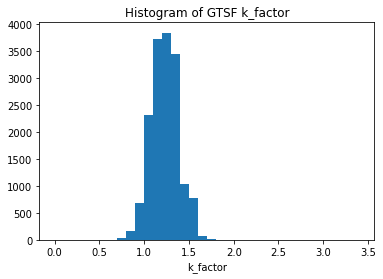

In [80]:
_ = plt.hist(df_gtsf['k_factor'], bins=[a * 0.1 for a in range(0, 35)])  # arguments are passed to np.histogram

plt.title("Histogram of GTSF k_factor")
plt.xlabel('k_factor')
plt.show()